# Group information

Names and RAs:

- Vinicius Forato Coracin 231528

- Guilherme Webster Chamoun 257111

## Objective:

To explore **deep learning** techniques, focused on **Convolutional Neural Networks**. In this task you'll be architecturing different CNNs to solve an image classification problem.

This **MUST** be developed using the pytorch and Sklearn libraries (PyTorch Lightning is **not** allowed).

*Tip: Use the Pillow (PIL) library to work with images with pytorch. Also, you can use [tqdm](https://github.com/tqdm/tqdm) library to see the progress of the training process.*

## Dataset

The dataset you should use is an adaptation of the "CIFAR10" dataset. The CIFAR10 dataset is a dataset of 32x32 images of 10 different classes, and is extensivelly used for classification of images using CNN.

In this work, You will only will select 3 classes [from CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). You also will only use a limited amount of the data of each class (the original dataset has 6000 images per class). For each class, the select 400 for training, 200 for validation and 300 for test. This is defined so that the training steps are faster, but it makes the problem harder, as we are working with few data points.

As in every machine learning task, we need to understand and analyze the data. From the way that the dataset was collected (data collection protocol, equipment used, people involved), to its final result (resulting files) and objective. When dealing with images, we usually want to track possible biases that different classes may have when collected. This dataset contains images of the target objects in a centered position in the foreground, having few biases related to the common background of some classes (for example: airplanes in the blue sky).

As in the other tasks we already covered the data analysis part, we will focus on the technical machine learning parts for this one. Just remember that images are another type of data and we also could (and **should**) analyze the information before applying machine learning techniques blindly.

## Load the dataset (2 Points)

When working with Pytorch, we need to create a "Dataset" class that usually will handle the data loading, as well as the data transformations, and will allow us to retrieve the data with the respective label.

Data transformations are an important part of Pytorch datasets, as we already studied in the lectures that data augmentation can be powerful in training deep neural networks. But some of those transformations are just to define the entry of the model as Pytorch tensors or normalizing data, which can be impactful as well.

Create a Pytorch Dataset and Dataloader with and without data augmentation for training data (to compare later). The `Dataset` class has 3 required methods: `__init__`, `__len__`, and `__getitem__`. In the code below we have some basic idea of an ImageDataset.

You can choose how to implement the image loading in the class:
- Inside the `__getitem__` method (low memory usage for each dataset instance, slower for training)
- Inside the `__init__` method (saves all images on memory, but training is faster)

Either implementation is ok, if the machine you're using supports the loading of all images this is probably better for performance.

For a deeper look at Pytorch datasets and dataloaders, look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

The images are already divided by folder for train, validation and test, and you should follow this order. The targets of each image are described in the filename in the following pattern: `[image_number]_[class].jpg`.

To create the data augmentation you can follow the `preparation` example below, and add different Pytorch transformations. A list of available transformations (as well as examples) can be found in the [official documentation (here)](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended).

In [ ]:
# Link with google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load dataset from google drive
root_path = "gdrive/MyDrive/Colab Notebooks/Lab03/cifar-10-batches-py/"
test_validation_path = "gdrive/MyDrive/Colab Notebooks/Lab03/cifar-10-batches-py/test_batch"

Mounted at /content/gdrive


In [ ]:
import torch
import torchvision
from torch import nn as nn
from torchvision.transforms import v2
import torchvision.transforms.v2 as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [ ]:
import pickle

# Function to unpickle a CIFAR-10 batch and return the images and labels
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        images = dict[b'data']
        labels = dict[b'labels']
    return images, labels

# Function to unpickle all 5 CIFAR-10 training batches and concat the data
def load_all_cifar_batches(root_path):
    images = []
    labels = []

    for batch in range(1, 6):
        file_path = os.path.join(root_path, f'data_batch_{batch}')
        batch_images, batch_labels = load_cifar_batch(file_path)
        images.append(batch_images)
        labels.extend(batch_labels)

    images = np.concatenate(images)
    labels = np.array(labels)
    return images, labels

In [ ]:
# Function to filter the selected classes from the training data
def filter_classes(images, labels, selected_classes):
    filtered_images = []
    filtered_labels = []

    for img, label in zip(images, labels):
        if label in selected_classes:
            filtered_images.append(img)
            filtered_labels.append(label)

    # Convert to NumPy arrays
    filtered_images = np.array(filtered_images)
    filtered_labels = np.array(filtered_labels)
    return filtered_images, filtered_labels

In [ ]:
# Selects only the specified number n of images from the entire dataset
def select_n_images(images, labels, selected_classes, num_images):
    num_images_per_class = num_images // len(selected_classes)
    selected_images, selected_labels = [], []

    for cls in selected_classes:
        class_images = [img for img, label in zip(images, labels) if label == cls]

        selected_images.append(class_images[:num_images_per_class])
        selected_labels.append([cls] * num_images_per_class)

    # Concatenates each set
    selected_images = np.concatenate(selected_images)
    selected_labels = np.concatenate(selected_labels)

    return (selected_images, selected_labels)

In [ ]:
# Defines the selected classes. Here we choose airplane, ship and truck
selected_classes = [0, 8, 9]

# Loads training data
train_images, train_labels = load_all_cifar_batches(root_path)
train_images, train_labels = filter_classes(train_images, train_labels, selected_classes)
train_images, train_labels = select_n_images(train_images, train_labels, selected_classes, 400)

# Loads validation and test sets
test_val_images, test_val_labels = load_cifar_batch(root_path + "test_batch")
test_val_images, test_val_labels = filter_classes(test_val_images, test_val_labels, selected_classes)
test_images = test_val_images[:len(test_val_images) // 2]
test_labels = test_val_labels[:len(test_val_labels) // 2]
val_images = test_val_images[len(test_val_images) // 2:]
val_labels = test_val_labels[len(test_val_labels) // 2:]
val_images, val_labels = select_n_images(val_images, val_labels, selected_classes, 200)
test_images, test_labels = select_n_images(test_images, test_labels, selected_classes, 300)

# Reshape the sets to be (n, 3, 32, 32)
train_images = train_images.reshape(-1, 3, 32, 32)
val_images = val_images.reshape(-1, 3, 32, 32)
test_images = test_images.reshape(-1, 3, 32, 32)

In [ ]:
# Set the expected input shape
input_width = 32
input_height = 32
nchannels = 3

# Data augmentation transformations
augmentation = transforms.Compose([
                                   v2.Lambda(lambda image : Image.fromarray(image.astype(np.uint8).transpose(1, 2, 0))),
                                   v2.RandomHorizontalFlip(p=0.5),
                                   v2.RandomResizedCrop(size=(32, 32), scale=(0.7, 1.0)),
                                  ])

# Transformations needed for preparing the data
preparation = transforms.Compose([
                                 v2.Resize((input_width,input_height), interpolation=transforms.InterpolationMode.BILINEAR,
                                                     max_size=None, antialias=True),
                                 v2.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                 ])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, root_dir, transform=None):
        self.images = images
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

# Training set without augmentation
train_set = ImageDataset(train_images, train_labels, root_path, preparation)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Training set with augmentation
aug_train_set = ImageDataset(train_images, train_labels, root_path, augmentation)
aug_train_loader = DataLoader(aug_train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation set
val_set = ImageDataset(val_images, val_labels, root_path, preparation)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Test set
test_set = ImageDataset(test_images, test_labels, root_path, preparation)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Number of images: 399
Images are 32x32x3


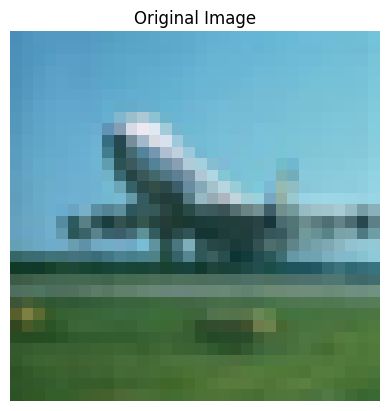

Class of the image: 0


Number of augmented images: 399


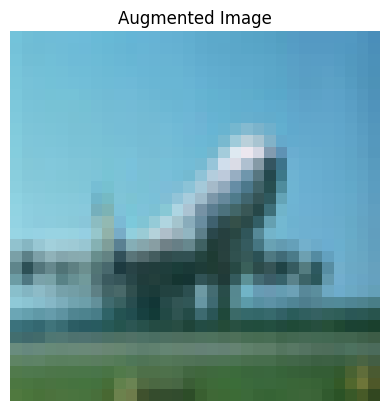

Class of the image:  0


In [ ]:
# Visualize images from the training set

# Plots the original image
print("Number of images:", len(train_set))
image, label = train_set[100]
image = image.transpose(1, 2, 0) # Converts the Tensor back to image shape
print(f"Images are {image.shape[0]}x{image.shape[1]}x{image.shape[2]}")
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()
print(f"Class of the image: {label}\n\n")

# Plots the augmented image
print("Number of augmented images:", len(aug_train_set))
image_augmented, label_augmented = aug_train_set[100]
plt.imshow(image_augmented)
plt.title("Augmented Image")
plt.axis('off')
plt.show()
print("Class of the image: ", label_augmented)

## Train a baseline model (1 Point)

Before going for the deep learning approach, you should test a baseline model in this problem. To do so, train a RandomForectClassifier, where the inputs are the flattened images (all pixes of 3 channels concatenated).

You should use the same train/validation/test division that you'll be using in the next section. You can use the Sklearn library for this task. Remember to test and plot a confusion matrix with the results.

In [ ]:
x_train = train_set.images
y_train = train_set.labels

aug_x_train = aug_train_set.images
aug_y_train = aug_train_set.labels

x_val = val_set.images
y_val = val_set.labels

x_test = test_set.images
y_test = test_set.labels

In [ ]:
# Function to flatten images
def flatten_images(images):
    return np.array([img.flatten() for img in images])

# Prepare the datasets: flattening the images
rf_x_train = flatten_images(train_images)
rf_x_val = flatten_images(val_images)
rf_x_test = flatten_images(test_images)

rf_y_train = np.array(train_labels)
rf_y_val = np.array(val_labels)
rf_y_test = np.array(test_labels)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model
model = RandomForestClassifier(n_estimators=200, max_depth=15)
model.fit(rf_x_train, rf_y_train)

# Inference on validation set
y_val_pred = model.predict(rf_x_val)
accuracy = accuracy_score(rf_y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Inference on test set
y_test_pred = model.predict(rf_x_test)
accuracy = accuracy_score(rf_y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.5758
Test Accuracy: 0.6567


In [ ]:
# Save the random forest model on the disk
import pickle

pickle_file = "gdrive/MyDrive/Colab Notebooks/Lab03/Models/rf.pkl"
pickle.dump(model, open(pickle_file, 'wb'))

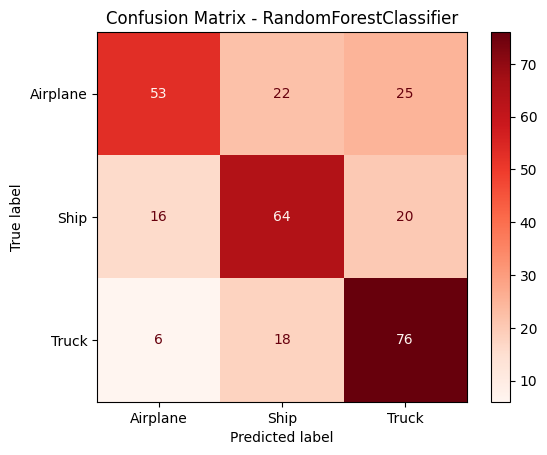

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Airplane', 'Ship', 'Truck'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix - RandomForestClassifier")
plt.show()

## Build a CNN (6 Points)

In this section, you should construct and validate a CNN architecture for the given problem.

It's required that you test at least the following parts of a CNN:
- Number of convolutional layers and different output sizes
- Kernel size of filters
- Number of training epochs
- Learning rate of the network
- Batchsize used in dataloader
- Stride on convolutional or pooling layers
- Different architecture for the final dense layer (with or without hidden layers and their size)

Also, you must compare at least for one network if the data augmentation is helping the training process or not.

Lastly, you must change the `Criterion` function to return the balanced accuracy instead of the normal one.

--------

The process to build a CNN is an exploratory analysis and should be done carefully. As this is a costly process, you will not test all possibilities between each other, you should interpret the results at each step and understand what is happening or not happening.

As this is a costly process, you should use the normal division of train/validation/test, instead of cross validation. Also, at each network built and trained/validated, you should look at the results to understand if any overfitting or underfitting is happening. Save the values of each batch of train and validation to analyze how the model performed over the epochs.

### Exploding/vanishing gradients

As we already learned, the weights of a neural network are updated using the backpropagation algorithm. As our network grows in depth, there are two problems that can occur with the backpropagation algorithm, known as Exploding and Vanishing gradients.

As both names imply, both conditions relate to a gradient calculation that goes out of control for some reason.

The exploding gradient can happen when the current weights generate a very large loss, and all the network weights are updated by a huge amount. This can lead to a cycle where the network is not able to learn because every learning step impacts too much the network, making it very unstable.

On the other side, the vanishing gradient will happen when the gradients get too small, and the updates are not able to propagate to the initial layers.

There are a couple of ways to solve those issues. The first is to use an activation function that is "non-saturating". The sigmoid function is an example of a saturating function because its derivative tends to 0 on larger positive or negative values. The best activation functions to avoid this issue are the ReLU and its variations (LReLU, PReLU, ELU, etc). All those examples help to mitigate the vanishing gradient.

Another important step is to initialize the weights of the network properly. Initializing the weights randomly can also lead to vanishing/exploding gradients in some situations. The common strategy is to use a heuristic. We are not going to cover this manner in a deeper aspect, but the Xavier initialization is already implemented in the example below.

Finally, the best thing to avoid vanishing and exploding gradients in a deep CNN is to use the Batch Normalization technique. This technique is a new operation on the CNN, that normalizes its input and adds a parameter for scale and another for shifting. This enables the network to learn the optimal scale and mean of the layer. This normalization uses the data of the batch of images being executed on the model to find the mean and standard deviation. In pytorch, there is a function to use this technique in the `nn` module: `nn.BatchNorm2d()`. The BatchNorm operation can be used before or after the activation function.

For example:
- Conv -> BatchNorm -> Activation(ReLU) -> Pooling
Or
- Conv -> Activation(ReLU) -> BatchNorm -> Pooling).

In this task, you may face problems concerning the stability and convergence of the network because of the exploding or vanishing gradients, and it is recommended that you use the techniques cited to avoid this issue.

In [ ]:
gpu = torch.cuda.is_available()

if gpu:
    print("GPU available!")
else:
    print("GPU not available!")

device = torch.device('cuda') if gpu else torch.device('cpu')

GPU not available!


**Example of train/validate code**

In the next cells, we show an example of how to develop the train/validation functions using pytorch. You don't need to use this code, but it is a place to start.

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        # Max Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features = 128 * 4 * 4, out_features=512)  # 4x4 comes from the down-sampling
        self.fc2 = nn.Linear(in_features = 512, out_features = n_classes)
        # Initialize the model weights
        self._initialize_weights()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        '''
        Initialize the network weights using the Xavier initialization.
        '''
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

In [ ]:
# Maps the labels [0, 8, 9] to be [0, 1, 2]
label_mapping = {
    0: 0,
    8: 1,
    9: 2,
}
def map_labels(targets):
    return torch.tensor([label_mapping[t.item()] for t in targets])

In [ ]:
# Training step

def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device):
    '''
    Function that trains the model for n_epochs
    Parameters:
        'model': an instance of a pytorch model.
        'train_loader': the test dataloader.
        'val_loader': the validation dataloader.
        'optimizer': an instance of an pytorch optmizer.
        'criterion': a custom function to calculate the loss and accuracy of the predictions of the batch.
        'n_epochs': number of epochs to train the model.
        'device': the device that the model is loaded on.
    '''

    train_losses, train_accuracies = [], []
    for epoch in range(n_epochs):
        train_loss, train_acc = 0.0, 0.0

        # Training loop
        for data in train_loader:
            loss, acc = train_batch(model, data, optimizer, criterion, device)
            train_loss += loss
            train_acc += acc

        # Average the losses and accuracies for each epoch
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Store losses and accuracies
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    return train_losses, train_accuracies


def train_batch(model, data, optimizer, criterion, device):
    '''
    Function that trains a batch of data
    '''
    model.train()
    ims, targets = data
    ims = ims.type(torch.float32).to(device=device)
    targets = map_labels(targets).to(device=device)
    preds = model(ims)
    loss, acc = criterion(model, preds, targets, device)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss, acc


def Criterion(model, preds, targets, device):
    '''
    Function that calculates the loss and accuracy of a batch predicted by the model.
    '''
    ce = nn.CrossEntropyLoss().to(device)
    targets = targets.long().to(device)
    loss = ce(preds, targets)
    pred_labels = torch.argmax(preds, dim=1)
    acc = (pred_labels == targets).sum().item() / targets.size(0)

    return loss, acc

In [ ]:
# Validation step

@torch.no_grad()
def validate_model(model, val_loader, criterion, device):
    '''
    Function that trains the model for n_epochs
    Parameters:
        'model': an instance of a pytorch model.
        'val_loader': the validation dataloader.
        'criterion': a custom function to calculate the loss and accuracy of the predictions of the batch.
        'device': the device that the model is loaded on.
    '''

    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    for data in val_loader:
        loss, acc = validate_batch(model, data, criterion, device)
        val_loss += loss
        val_acc += acc

    # Average the losses and accuracies for each epoch
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")
    return val_loss, val_acc


@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims = ims.type(torch.float32).to(device=device)
    targets = map_labels(targets).to(device=device)
    preds = model(ims)
    loss, acc = criterion(model, preds, targets, device)

    return loss, acc

In [ ]:
# Instantiate the CNN
input_shape = (3, 32, 32)
n_classes = 3
model = CNN(input_shape, n_classes)

# Hyperparameters
learning_rate = 0.001
n_epochs = 15

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training the model
train_losses, train_acc = train_model(model, train_loader, val_loader, optimizer, Criterion, n_epochs, device)

# Model's validation
#val_losses, val_acc = validate_model(model, test_loader, Criterion, device)

Validation Loss: 1.4020, Validation Acc: 0.4717
Epoch [1/15], Train Loss: 3.4839, Train Acc: 0.4713
Validation Loss: 0.9862, Validation Acc: 0.5417
Epoch [2/15], Train Loss: 1.0116, Train Acc: 0.6168
Validation Loss: 0.8838, Validation Acc: 0.6190
Epoch [3/15], Train Loss: 0.5838, Train Acc: 0.7377
Validation Loss: 0.8274, Validation Acc: 0.6577
Epoch [4/15], Train Loss: 0.5171, Train Acc: 0.7704
Validation Loss: 0.7209, Validation Acc: 0.6905
Epoch [5/15], Train Loss: 0.3853, Train Acc: 0.8503
Validation Loss: 0.7469, Validation Acc: 0.6741
Epoch [6/15], Train Loss: 0.2983, Train Acc: 0.9050
Validation Loss: 0.7280, Validation Acc: 0.6845
Epoch [7/15], Train Loss: 0.2182, Train Acc: 0.9444
Validation Loss: 0.9091, Validation Acc: 0.6473
Epoch [8/15], Train Loss: 0.2541, Train Acc: 0.8885
Validation Loss: 0.7955, Validation Acc: 0.7381
Epoch [9/15], Train Loss: 0.1413, Train Acc: 0.9639
Validation Loss: 0.7436, Validation Acc: 0.7307
Epoch [10/15], Train Loss: 0.0848, Train Acc: 0.9904

    Conclusions:
    
    - Changing the number of convolutional layers:
        - Two Convolutional Layers best validation score: 69.94%
        - Three Convolutional Layers best validation score: 75.89%
        - Four Convolutional Layers best validation score: 74.26%
    So we choose three convolutional layers

    - Changing the learning rate of the network:
        - 0.01 best validation score: 59.67%
        - 0.001 best validation score: 73.51%
        - 0.0001 best validation score: 71.13%
        - 0.00001 best validation score: 64.73%
    So we choose use the learning rate of 0.0001

    - Changing the batchsize used in dataloader:
        - Batchsize of 32 best validation score: 68.90%
        - Batchsize of 64 best validation score: 69.05%
        - Batchsize of 128 best validation score: 69.79%
    As expected, as we increase the batch_size, the fitting of the model gets better. However,
    it also increases the computacional cost, so we choose to use batch_size = 128, instead of
    bigger batches.

    - Changing the use of strides on convolutional or pooling layers:
        - Pooling layers best validation score: 68.01%
        - Strides (size = 2) best validation score: 58.18%
    So we choose to use MaxPooling2D layers

    - Using or no final dense layers in the architeture:
        - No final dense layers (FCN) best validation score: 68.01%
        - One final dense layer best validation score: 65.33%
        - Two final dense layers best validation score: 68.45%
    So we choose to use two final dense layers

    - Changing the number of training epochs:
        The best number of training epochs depended on the parameter being
        tested. We fixed the max nummber of epochs as 15, but the best
        validation score usually was achieved between the 5th and the 10th epoch.

    The parameters were changed one at a time, while keeping the other ones constant.
    That way, we found that the best parameters were 3 convolutional layers, pooling
    layers, two final dense layers, kernel size of 3, batchsize of 128 and learning_rate of 0.001.

    We also tried to use data augmentation, using aug_train_data instead of the
    train_data dataloader. But, in this case, our validation accuracy was only 46.88%,
    not being able to beat the previous result.
    
    In conclusion, our best validation accuracy was 75.89%, and the best test accuracy was 71.15%

In [ ]:
from sklearn.metrics import balanced_accuracy_score

def balanced_acc_criterion(model, preds, targets, device):
    """
    Function that calculates the loss and balanced accuracy of a batch predicted by the model.
    """
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())

    # Get the predicted labels
    pred_labels = torch.max(preds.data, 1)[1]

    # Move the predictions and targets to the CPU for balanced accuracy calculation
    pred_labels_np = pred_labels.cpu().numpy()
    targets_np = targets.cpu().numpy()

    # Calculate balanced accuracy using sklearn's balanced_accuracy_score
    balanced_acc = balanced_accuracy_score(targets_np, pred_labels_np)

    return loss, balanced_acc

In [ ]:
# Training the model using balanced accuracy criterion
train_losses, train_acc = train_model(model, train_loader, val_loader, optimizer, balanced_acc_criterion, n_epochs, device)

# Model's validation
val_losses, val_acc = validate_model(model, test_loader, balanced_acc_criterion, device)

        Conclusions:
            We got an balanced accuracy score of 70.61% for the validation set
            and of 72.20% for the test set. This results are close to the
            obtained for simple accuracy score (what was expected, since the
            classes in our sets have the same number of samples).

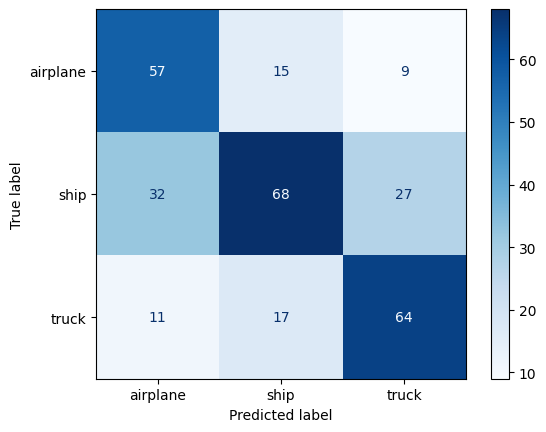

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Supondo que você tenha um modelo carregado e um 'test_loader' com as imagens e rótulos para teste
all_preds = []
all_labels = []

# Loop para iterar sobre os dados de teste
for data in test_set:
    image, label = data
    image = torch.tensor(image).float().unsqueeze(0)
    predicted = model.forward(image).detach().numpy()
    predicted_label = np.argmax(predicted)
    all_preds.append(predicted_label)
    all_labels.append(label)

# Gerar a matriz de confusão
for i in range(len(all_labels)):
    if all_labels[i] == 8:
        all_labels[i] = 1
    elif all_labels[i] == 9:
        all_labels[i] = 2
conf_matrix = confusion_matrix(all_preds, all_labels)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['airplane', 'ship', 'truck'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


**Saving models**

As the CNN training process can take some time, is interesting to save your models, to avoid re-training in the case of a crash or just to save your work for other time.

The next cell shows a simple code to save and load pytorch models. Remember to keep the class of the model in the same way, as the state_dict will not work if you change the architecture. Create new classes for different tests, with names that correctly describe what is being tested.

**Note**: If you're using google colab, just saving the model is not enough. You need to save it for a folder in your google Drive, or download the files after saving them.

In [ ]:
# ===== How to save a pytorch model =====
## Since you have the class of the model, you can save the weights
## IMPORTANT: If you change the class implementation you will NOT be able to load the model again.

path_to_save = "gdrive/MyDrive/Colab Notebooks/Lab03/Models/model01"
torch.save(model.to('cpu').state_dict(), path_to_save)

In [ ]:
# ===== How to load a pytorch model =====

## Instantiate the model class as usual
path_to_save = "gdrive/MyDrive/Colab Notebooks/Lab03/Models/model01"
model = CNN(input_shape, n_classes)

## Load the state dict saved before
state_dict  = torch.load(path_to_save)

## Load the weights in the model
model.load_state_dict(state_dict)

## Send the model to the GPU
model = model.to(device)

<ipython-input-73-155f236659c6>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict  = torch.load(path_to_save)


### Early stoping regularization (EXTRA: 1 Point)

~This can only be done if you are able to find a CNN that was able to overfit the train dataset.~

~If that is the case,~ Change the training function in order to perform an [early stopping](https://en.wikipedia.org/wiki/Early_stopping). The early stopping technique using validation is a technique to stop the training process when a defined condition is achieved. Find this condition and change the code.

Discuss the results and why they happened (it works? Why?)


In [ ]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs, device, patience=3):
    '''
    Function that trains the model for n_epochs with early stopping
    Parameters:
        'model': an instance of a PyTorch model.
        'train_loader': the training dataloader.
        'val_loader': the validation dataloader.
        'optimizer': an instance of a PyTorch optimizer.
        'criterion': a custom function to calculate the loss and accuracy of the predictions of the batch.
        'n_epochs': number of epochs to train the model.
        'device': the device that the model is loaded on.
        'patience': the number of epochs to wait without improvement in validation loss before stopping.
    '''

    train_losses, val_losses = [], []
    best_val_acc = float('-inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for data in train_loader:
            loss, acc = train_batch(model, data, optimizer, criterion, device)
            train_loss += loss
            train_acc += acc

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss, val_acc = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                model.load_state_dict(torch.load('best_model.pth'))
                return train_losses, val_losses

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, val_losses

In [ ]:
# Training the model
train_losses, train_acc = train_model(model, train_loader, val_loader, optimizer, Criterion, n_epochs, device)

Validation Loss: 1.0480, Validation Acc: 0.5804
Epoch [1/15], Train Loss: 4.0755, Val Loss: 1.0480
Validation Loss: 0.9863, Validation Acc: 0.6071
Epoch [2/15], Train Loss: 0.8674, Val Loss: 0.9863
Validation Loss: 0.8541, Validation Acc: 0.5997
Epoch [3/15], Train Loss: 0.6974, Val Loss: 0.8541
Validation Loss: 0.8373, Validation Acc: 0.5967
Epoch [4/15], Train Loss: 0.5839, Val Loss: 0.8373
Validation Loss: 0.7829, Validation Acc: 0.6815
Epoch [5/15], Train Loss: 0.4892, Val Loss: 0.7829
Validation Loss: 0.8402, Validation Acc: 0.6354
Epoch [6/15], Train Loss: 0.3887, Val Loss: 0.8402
Validation Loss: 0.7545, Validation Acc: 0.6667
Epoch [7/15], Train Loss: 0.3201, Val Loss: 0.7545
Validation Loss: 0.7791, Validation Acc: 0.7188
Epoch [8/15], Train Loss: 0.2834, Val Loss: 0.7791
Validation Loss: 0.8683, Validation Acc: 0.6384
Epoch [9/15], Train Loss: 0.2208, Val Loss: 0.8683
Validation Loss: 0.7440, Validation Acc: 0.7039
Epoch [10/15], Train Loss: 0.1659, Val Loss: 0.7440
Validatio

<ipython-input-137-91d803ee1e3c>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


        Conclusions:
            Stopping the training early, we were able to find the best model in
            just 11 epochs, instead of 15. This way, we guarantee that the model
            with best accuracy on validation set will be chosen, avoiding the
            overfitting. The best validation accuracy we were able to find was
            of 71.88%, what is almost equal the best accuracy find previously.

## Interpertability on CNNs (1 point)

The Gradient-weighted Class Activation Mapping (Grad-CAM) technique uses the gradient of one or more convolutional layers to highlight the regions of the image that were more impactful to a prediction. For more details, you can read [this paper](https://arxiv.org/abs/1610.02391).

The idea is to use the gradient to create a heatmap indicating the parts that had more weight on the decision for a given sample.

In the next cells, the Grad-CAM code is defined for one layer. You should use this code to test a few images of your best CNN defined in the previous sections. You can change the visualizations if you want.

Analyze the results of Grad-CAM for different images and classes, and discuss whether the model is focusing or not on the right parts of the image and why this may be happening. Feel free to change the code below to visualize in a different way (different quantity of images, different labeling, etc).

-------

**Important: The code below has some assumptions about the network architecture. If the model class is built in a different way you MUST change the implementation of the `get_activations` function.**

In [ ]:
labels_map = {
    0: "Airplane",
    1: "Ship",
    2: "Truck"
}

def get_activations(model, image, device):
    '''
    Return the activations from the last convolutional layer of the model.
    '''
    # Move the input image to the selected device (GPU or CPU)
    image = image.to(device)

    # Forward pass until the last convolutional layer
    x = model.conv1(image)
    x = model.pool(F.relu(model.bn1(x)))

    x = model.conv2(x)
    x = model.pool(F.relu(model.bn2(x)))

    x = model.conv3(x)
    x = F.relu(model.bn3(x))  # This is the output of the last convolutional layer

    return x  # Return the activations


def get_output_of_the_model(model, image, device):
    '''
    This function is just a "forward" call in "eval" mode, in order to have the predictions for a given image.
    '''
    # Put the model in evaluation mode
    model.eval()

    # Move input tensor (image) to the selected device (GPU or CPU)
    image = image.to(device)

    # Execute the model to get the output predictions
    output = model(image)

    return output

def get_activ(layer, target_layer, activ):
    '''
    This function will recursively search for the layer to be used in Grad-CAM and compute the mean gradient of the output channels.
    '''
    if target_layer == layer:
        grad = layer.weight.grad  # Get the gradient for the layer's weights

        # Multiply activations by the average gradient for each channel
        for i in range(activ.shape[1]):
            activ[:, i, :, :] *= grad[i].mean()

        return activ
    else:
        # Recursively check other layers
        if hasattr(layer, '__getitem__'):  # Check if it's a sequential-like container
            for in_layer in layer:
                activ = get_activ(in_layer, target_layer, activ)
                if activ is not None:
                    return activ

    return None

In [ ]:
def get_heatmap(model, image, target_layer, device):
    '''
    Find a heatmap for a given image and target_layer of the model.
    "device" is the device where the model is running (to use GPU when available)
    '''
    image_in = image.unsqueeze(0)

    # Get the output of the feature extractor (activations from the last conv layer)
    activ  = get_activations(model, image_in, device)

    # Get the predictions at the output of the decision layer
    logits = get_output_of_the_model(model, image_in, device)

    # Get the most confident prediction
    pred   = logits.max(-1)[-1]

    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)

    # If you used the nn.Sequential(), change this line to be "model.sequential.children()"
    for layer in model.children():
        res = get_activ(layer, target_layer, activ)
        if res is not None:
            break

    if res is None:
        raise Exception("Layer not found!")

    heatmap = torch.mean(res, dim=1)[0].cpu().detach()

    heatmap = heatmap.squeeze(0).numpy()
    # Normalize image with minmax
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    # Resize figure to be in the same size as the input image
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

    return heatmap, labels_map[pred.cpu().detach().numpy()[0]]

def display_image_with_heatmap(img, heatmap, scale, ax, true_label, predicted_label):
    '''
    Display the image with the heatmap in a given scale, with labels.
    '''
    heatmap = np.uint8(255.0 * heatmap)
    width   = int(heatmap.shape[1] * scale)
    height  = int(heatmap.shape[0] * scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img     = 255 * (img - np.min(img)) / (np.max(img) - np.min(img))
    img     = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255 - heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap * 0.3 + img * 0.7)

    ax.imshow(heatmap)
    ax.set_title(f"True: {true_label} || Predicted: {predicted_label}", {'fontsize': 25})


<ipython-input-61-e7488774c2a4>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gdrive/MyDrive/Colab Notebooks/Lab03/Models/model01"))


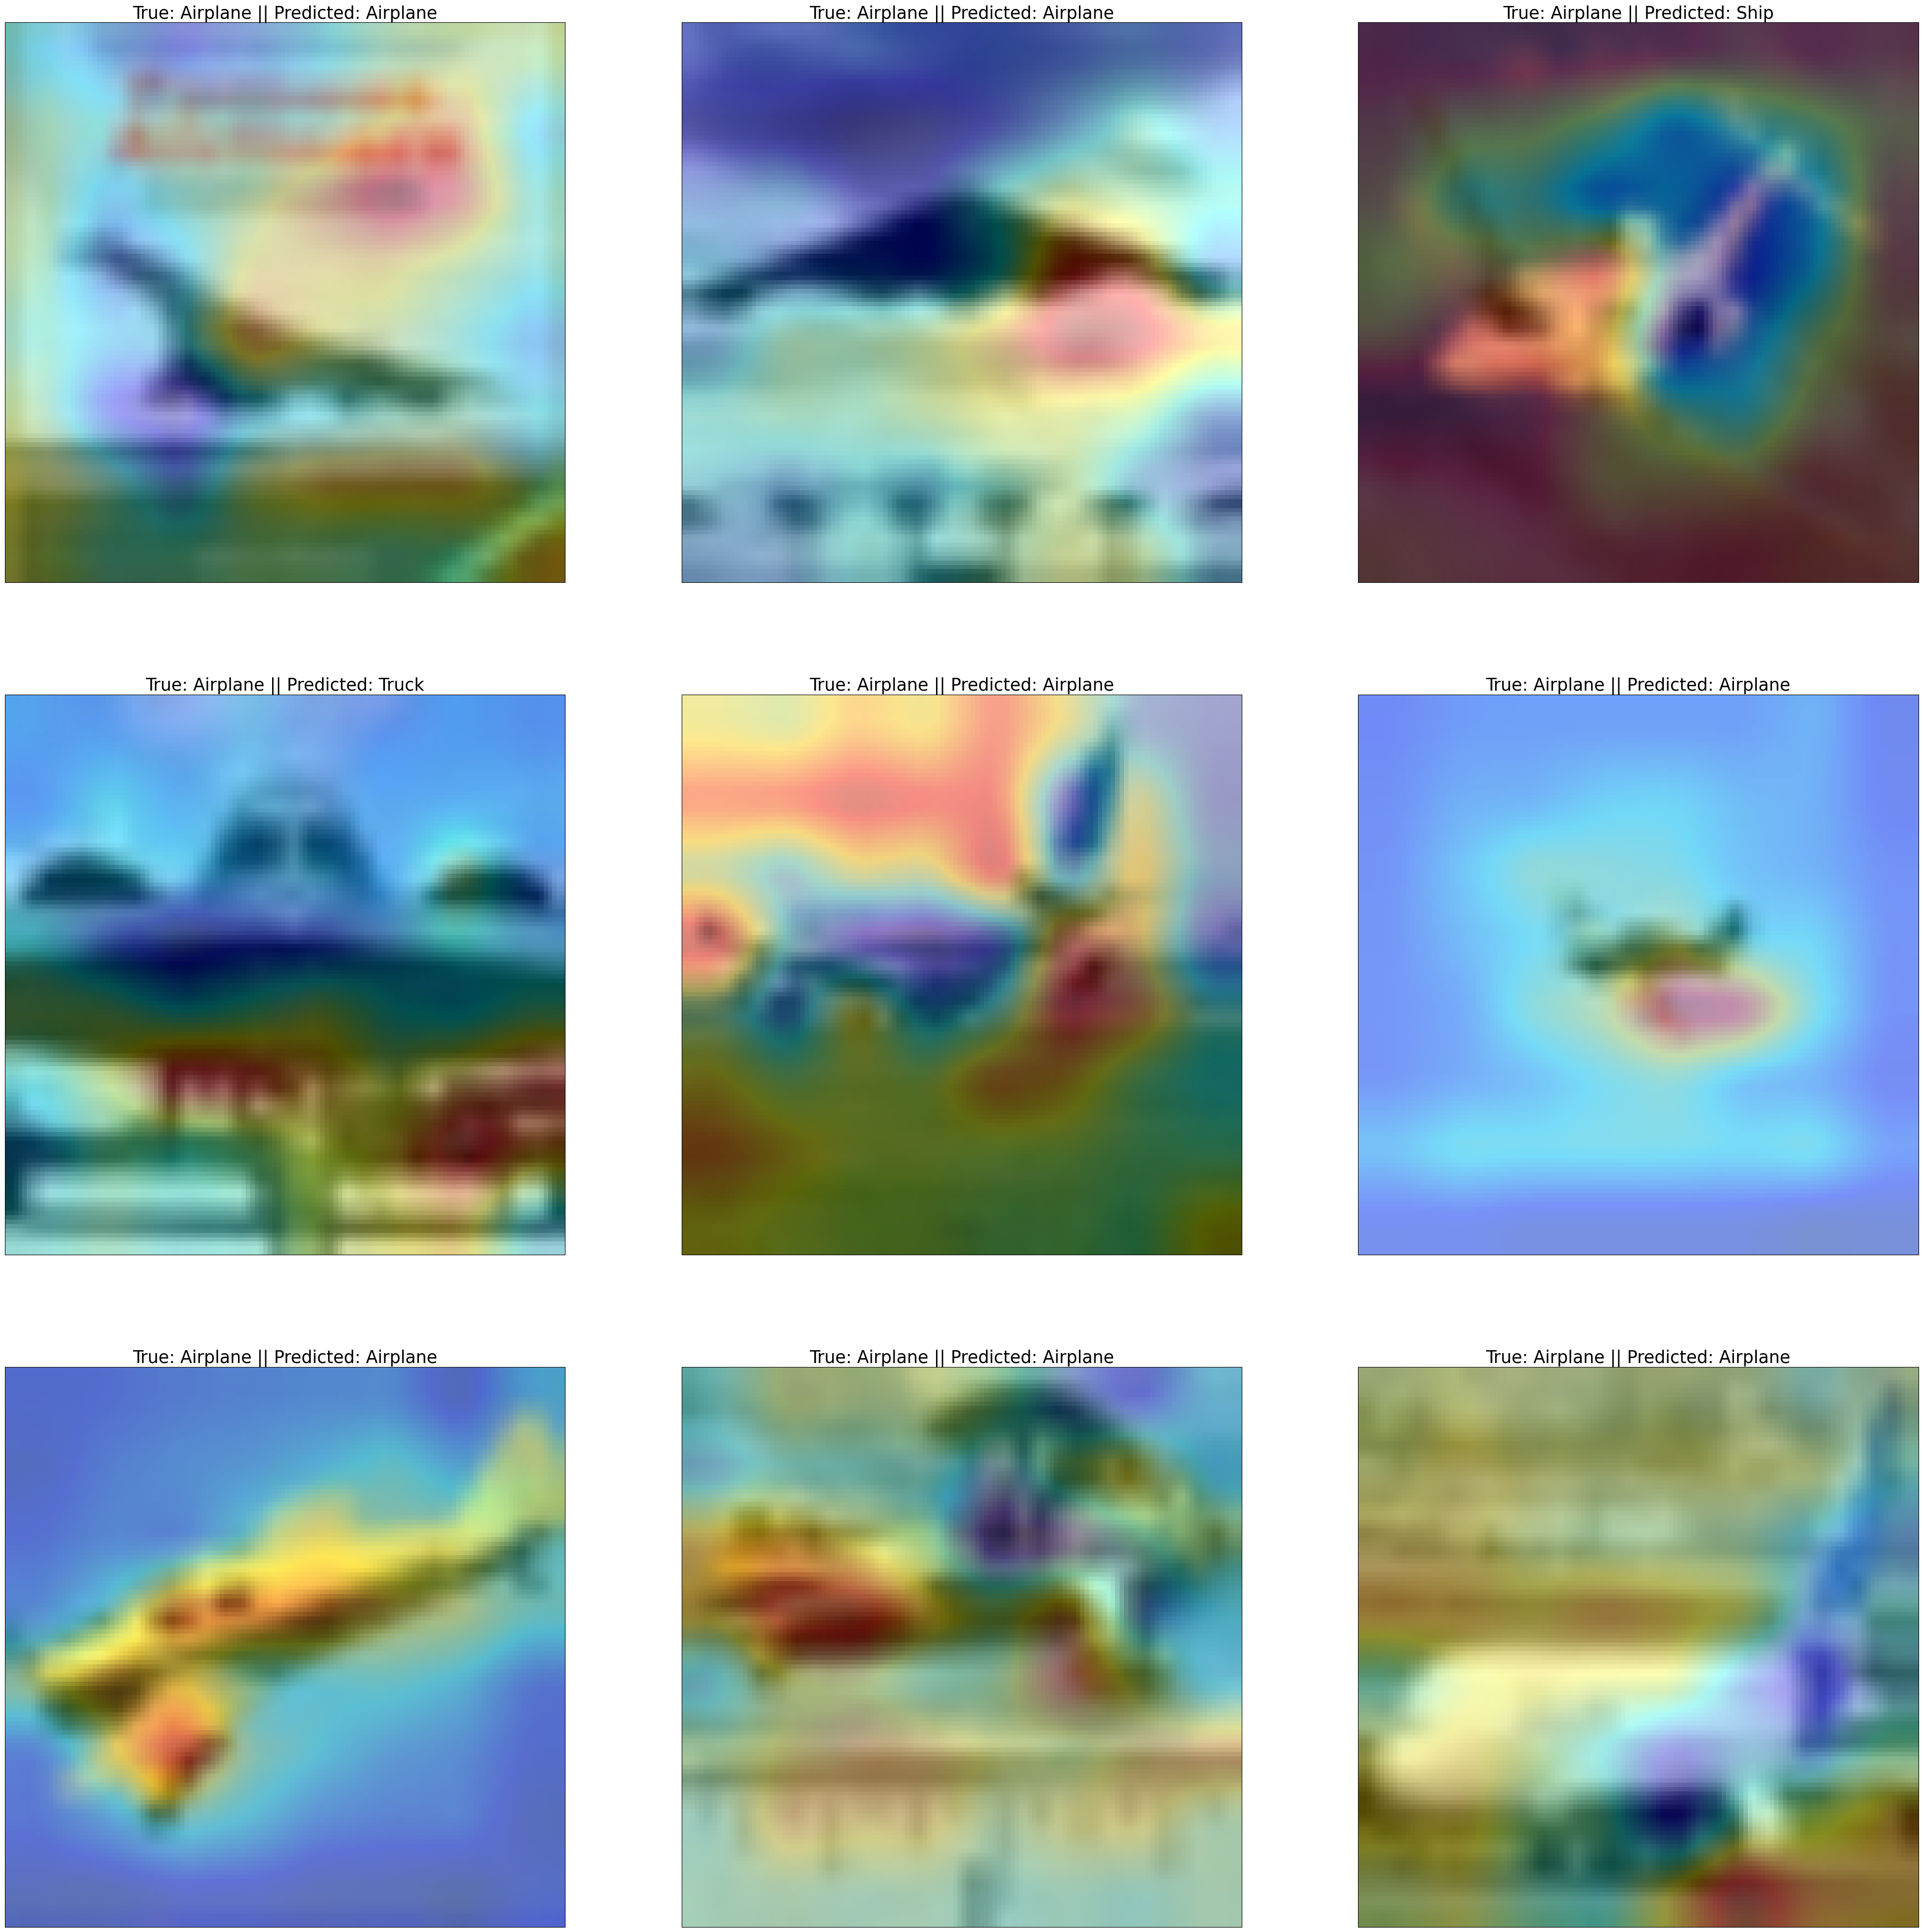

In [ ]:
# Plot multiple images and heatmaps
fig, axes = plt.subplots(3, 3, figsize=(50, 50), subplot_kw={'xticks': [], 'yticks': []})

model = CNN(input_shape, n_classes)

# Let's reload the model and see how it performs
model.load_state_dict(torch.load("gdrive/MyDrive/Colab Notebooks/Lab03/Models/model01"))
model.to(device)

for i, ax in enumerate(axes.flat):
    # Load the image and true label from the test dataset
    image, true_label = test_set[i * 10]

    # Verifique se a imagem já é um tensor PyTorch
    if isinstance(image, np.ndarray):
        image = torch.tensor(image).float()
    image = image.to(device)

    # Generate the Grad-CAM heatmap
    heatmap, predicted_label = get_heatmap(model, image, model.conv3, device)

    # Convert the image back to (Height x Width x Channels)
    image = image.permute(1, 2, 0).cpu().numpy()

    # Display the image with the heatmap
    display_image_with_heatmap(image, heatmap, 4, ax, labels_map[true_label], predicted_label)

        Above we could see how our model predicts an image to be of class 'airplane'.
        We could see that our model searchs for a "T-shape" vehicle, that is, a
        long vehicle with a pair of wings. Particularly, the model isn't great
        to predict airplanes viewed from the front (such as the forth image, where
        it predicted to be a truck), probably for the lack of samples with airplanes
        in this position.

## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.